## Frequent category imputation | Mode imputation

Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a **complete dataset** that can be used to train machine learning models.

Mode imputation consists of replacing all occurrences of missing values (NA) within a variable by the mode, which in other words refers to the **most frequent value** or **most frequent category**.


### Which variables can I impute with most frequent / mode Imputation?

Although the mode, or most frequent value can be calculated for both numerical and categorical variables, in practice, we only use this technique on categorical variables. The reason is that for numerical variables, the mean or the median tend to better represent the average value of the population.


### Assumptions

- Data is missing completely at random (MCAR)
- The missing observations, most likely look like the majority of the observations in the variable (aka, the mode)

The rationale is that the value that should have been seen for the missing observation is most likely the most frequent value or category of the variable.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)


### Limitations

- Distortion the relation of the most frequent label with other variables within the dataset
- May lead to an over-representation of the most frequent label if there is a big number of NA


### When to use mode / most frequent category imputation?

- Data is missing completely at random
- No more than 5% of the variable contains missing data

## In this demo:

We will use the House Prices dataset to demonstrate how to do mode imputation in categorical variables.

- To download the dataset please refer to the lecture **Datasets** in **Section 1** of the course.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

### House Price dataset

In [4]:
# let's load the dataset with a few columns for the demonstration

# these are categorical columns and the target SalePrice
cols_to_use = ['BsmtQual', 'FireplaceQu', 'SalePrice']

data = pd.read_csv('../../../data/house-prices/train.csv', usecols=cols_to_use)
data.head()

,BsmtQual,FireplaceQu,SalePrice
0,Gd,NaN,208500
1,Gd,TA,181500
2,Gd,TA,223500
3,TA,Gd,140000
4,Gd,TA,250000


In [5]:
# let's inspect the percentage of missing values in each variable

data.isnull().mean()

BsmtQual       0.025342
FireplaceQu    0.472603
SalePrice      0.000000
dtype: float64

The variable BsmtQual contains only a few observations with NA (2.5), therefore, replacing those observations with the value of the most frequent category is a good approach.

On the other hand, the variable FireplaceQu, contains missing data in almost half of the observations. Therefore, replacing those with the most frequent category is most likely going to distort the relationship of the most frequent category with the sale price. 

In addition, if so many observations in FireplaceQu are missing, it could be for a reason and not just at random, so we could be better off capturing that somehow with a different imputation technique. We will see how in the next notebook. For now, let's explore the effect of replacing NA by the most frequent categories when missing data is few or a lot.

### Imputation important

Imputation should be done over the training set, and then propagated to the test set. This means that the most frequent category has to be selected from the training set, and used to replace NA both in train and test sets.

In [6]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data,
    data['SalePrice'], # target
    test_size=0.3, # percentage of observations in the test set
    random_state=0) # seed for reproducibility

X_train.shape, X_test.shape

((1022, 3), (438, 3))

#### BsmtQual

In [7]:
# let's remind ourselves of the % of missing values
X_train['BsmtQual'].isnull().mean()

0.023483365949119372

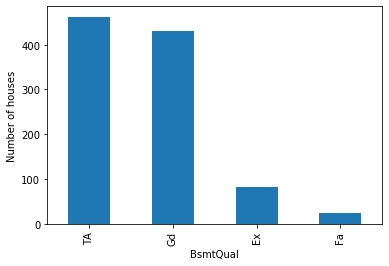

In [8]:
# let's inspect the number of observations per category in BsmtQual

# we used this line of code in section 3 on variable characteristics

# value_counts() counts the amount of houses that show each of the labels
# in the variable indicated below

X_train['BsmtQual'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('BsmtQual')
plt.ylabel('Number of houses');

In [9]:
# Let's find the most frequent category for BsmtQual

X_train['BsmtQual'].mode()

0    TA
dtype: object

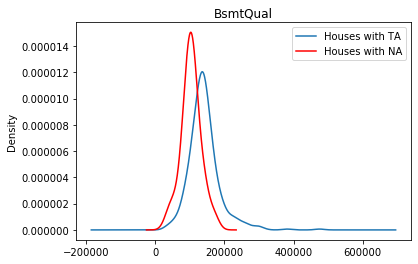

In [10]:
# let's plot the distribution of the target for the houses that:

# * show the most frequent category or
# * those that show missing data

fig = plt.figure()
ax = fig.add_subplot(111)

# select and plot houses with the most frequent label
X_train[X_train['BsmtQual']=='TA']['SalePrice'].plot(kind='kde', ax=ax)

# select and plot houses with missing data in the variable
X_train[X_train['BsmtQual'].isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')

# add the legend
lines, labels = ax.get_legend_handles_labels()
labels = ['Houses with TA', 'Houses with NA']
ax.legend(lines, labels, loc='best')

# add figure title
plt.title('BsmtQual');

The plot above indicates that the houses with missing data cost overall less than those with the label TA. Therefore, replacing missing values by TA, could affect the overall distribution, if there were a lot of NA.

In [11]:
# I keep the original distribution of SalePrice for the most
# frequent category for later

# the use of tmp is common to name temporal variables

tmp = X_train[X_train['BsmtQual']=='TA']['SalePrice']

In [13]:
# Let's fill na in both train and test

# I use the fillna() method from pandas

# with the argument inplace=True, I indicate to pandas
# that I want the values replaced in the same dataset

X_train['BsmtQual'].fillna('TA', inplace=True)
X_test['BsmtQual'].fillna('TA', inplace=True)

In [14]:
# check that NA have been filled

X_train['BsmtQual'].isnull().sum()

0

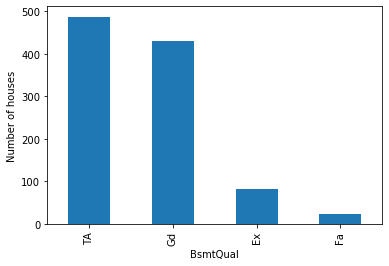

In [15]:
# evaluate effect on distribution of categories

X_train['BsmtQual'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('BsmtQual')
plt.ylabel('Number of houses');

From the above plot, we see that now there are a few more houses with the label TA, which are those that before contained NA, but the overall effect on the distribution is not dramatic. The plot looks almost identical to that one before the imputation.

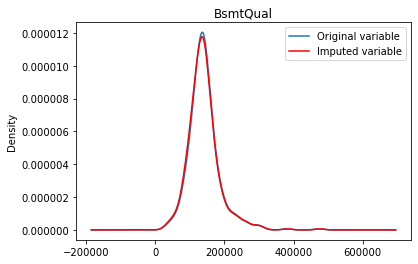

In [16]:
# did the distribution of SalePrice for the most frequent category change?
# let's have a look

fig = plt.figure()
ax = fig.add_subplot(111)

# original distribution of salePrice for houses with most frequent label
# remember I captured this a few cells up in the notebook
tmp.plot(kind='kde', ax=ax)

# distribution of the variable after imputation
X_train[X_train['BsmtQual'] == 'TA']['SalePrice'].plot(
    kind='kde', ax=ax, color='red')

# add the legend
lines, labels = ax.get_legend_handles_labels()
labels = ['Original variable', 'Imputed variable']
ax.legend(lines, labels, loc='best')

# add title
plt.title('BsmtQual');

The distribution of house prices between the original and imputed variable is quite similar, because the number of missing data was small. We expected this behaviour.

Let's explore the effect of mode imputation when the percentage of missing data is high.

#### FirePlaceQu

In [17]:
# let's remind ourselves of the % of missing values
X_train['FireplaceQu'].isnull().mean()

0.46771037181996084

Text(0, 0.5, 'Number of houses')

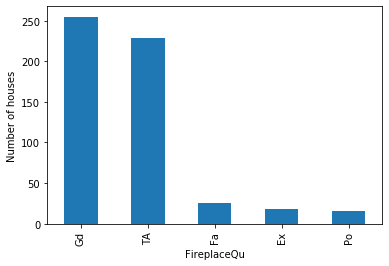

In [18]:
# let's inspect the number of observations per category

X_train['FireplaceQu'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('FireplaceQu')
plt.ylabel('Number of houses')

In [19]:
# Let's find the most frequent category for FirePlaceQu

X_train['FireplaceQu'].mode()

0    Gd
dtype: object

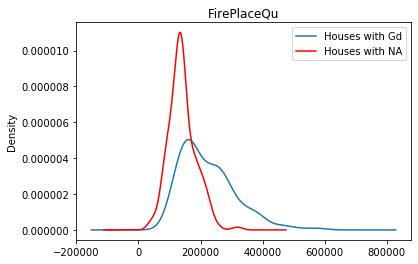

In [20]:
# let's plot the distribution of the target for the houses that
# show the most frequent category and those that show missing data

fig = plt.figure()
ax = fig.add_subplot(111)

# houses with the most frequent label for FirePlaceQu
X_train[X_train['FireplaceQu']=='Gd']['SalePrice'].plot(kind='kde', ax=ax)

# houses with missing data in FirePlaceQu
X_train[X_train['FireplaceQu'].isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')

# add the legend
lines, labels = ax.get_legend_handles_labels()
labels = ['Houses with Gd', 'Houses with NA']
ax.legend(lines, labels, loc='best')

plt.title('FirePlaceQu');

The distributions are quite different, houses with missing data cost overall less than those with the label Gd.

In [21]:
# I keep the original distribution of SalePrice for houses
# that show Gd in FirePlaceQu, for later.

tmp = X_train[X_train['FireplaceQu']=='Gd']['SalePrice']

In [23]:
# Let's fill na in both train and test

X_train['FireplaceQu'].fillna('Gd', inplace=True)
X_test['FireplaceQu'].fillna('Gd', inplace=True)

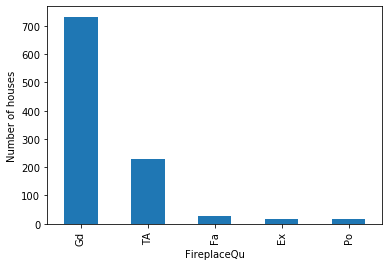

In [25]:
# let's inspect the number of observations per category

X_train['FireplaceQu'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('FireplaceQu')
plt.ylabel('Number of houses');

In this case, we see a big distortion in the original distribution of the variable. Now we have a lot more houses that contain the variable Gd, respect to the houses that show the other variables. Originally, half of the observartions in FirePlaceQu were missing. Now, all of those values contain Gd. That is why, we observe a big increase in Gd in the bar plot. 

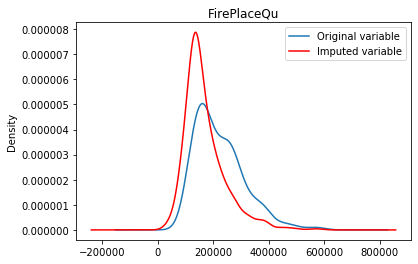

In [26]:
# let's plot the distribution of the target for the original variable
# fand the imputed variable

fig = plt.figure()
ax = fig.add_subplot(111)

# original distribution of the variable
# remember I captured this a few cells up in the notebook
tmp.plot(kind='kde', ax=ax)

# distribution of the variable after imputation
X_train[X_train['FireplaceQu'] == 'Gd']['SalePrice'].plot(
    kind='kde', ax=ax, color='red')

# add the legend
lines, labels = ax.get_legend_handles_labels()
labels = ['Original variable', 'Imputed variable']
ax.legend(lines, labels, loc='best')

plt.title('FirePlaceQu');

The average House value for the most frequent category has decreased quite dramatically after adding the house values of the NA, following re-categorisation of NA as the most frequent label.

Thus, the importance of this particular label for prediction of house price, is masked or changed by the addition of missing values. 

In cases like this, when the percentage of missing values is so high (~50%) we are better off creating a new category to enclose the observations with NA. I will show this in the next lecture.

**That is all for this demonstration. In later sections I will show you how to do mode imputation with scikit-learn and feature engine as part of a machine learning pipeline.**